In [1]:
# !yes | pip uninstall -q tensorflow
# !pip install -q tensorflow==2.14.0
# import tensorflow as tf
# tf.__version__

Proceed (Y/n)? yes: stdout: Broken pipe


'2.14.0'

In [2]:
import os
from tqdm import tqdm
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tensorflow.keras as keras
from keras.callbacks import EarlyStopping,ModelCheckpoint
import tensorflow as tf
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import warnings
warnings.filterwarnings('ignore')

In [3]:
#Files
path='../data/competition_data/'
pd.DataFrame(os.listdir(path),columns=['Files'])

,Files
0,meningioma_tumor
1,glioma_tumor
2,pituitary_tumor
3,normal


In [5]:
train_data_dir =path
batch_size = 32
target_size = (224, 224)
validation_split = 0.2
train= tf.keras.preprocessing.image_dataset_from_directory(
    train_data_dir,
    validation_split=validation_split,
    subset="training",
    seed=200,
    image_size=target_size,
    batch_size=batch_size,
)
validation= tf.keras.preprocessing.image_dataset_from_directory(
    train_data_dir,
    validation_split=validation_split,
    subset="validation",
    seed=44,
    image_size=target_size,
    batch_size=batch_size,
)

NameError: name 'path' is not defined

In [5]:
class_names = train.class_names
class_names

['glioma_tumor', 'meningioma_tumor', 'normal', 'pituitary_tumor']

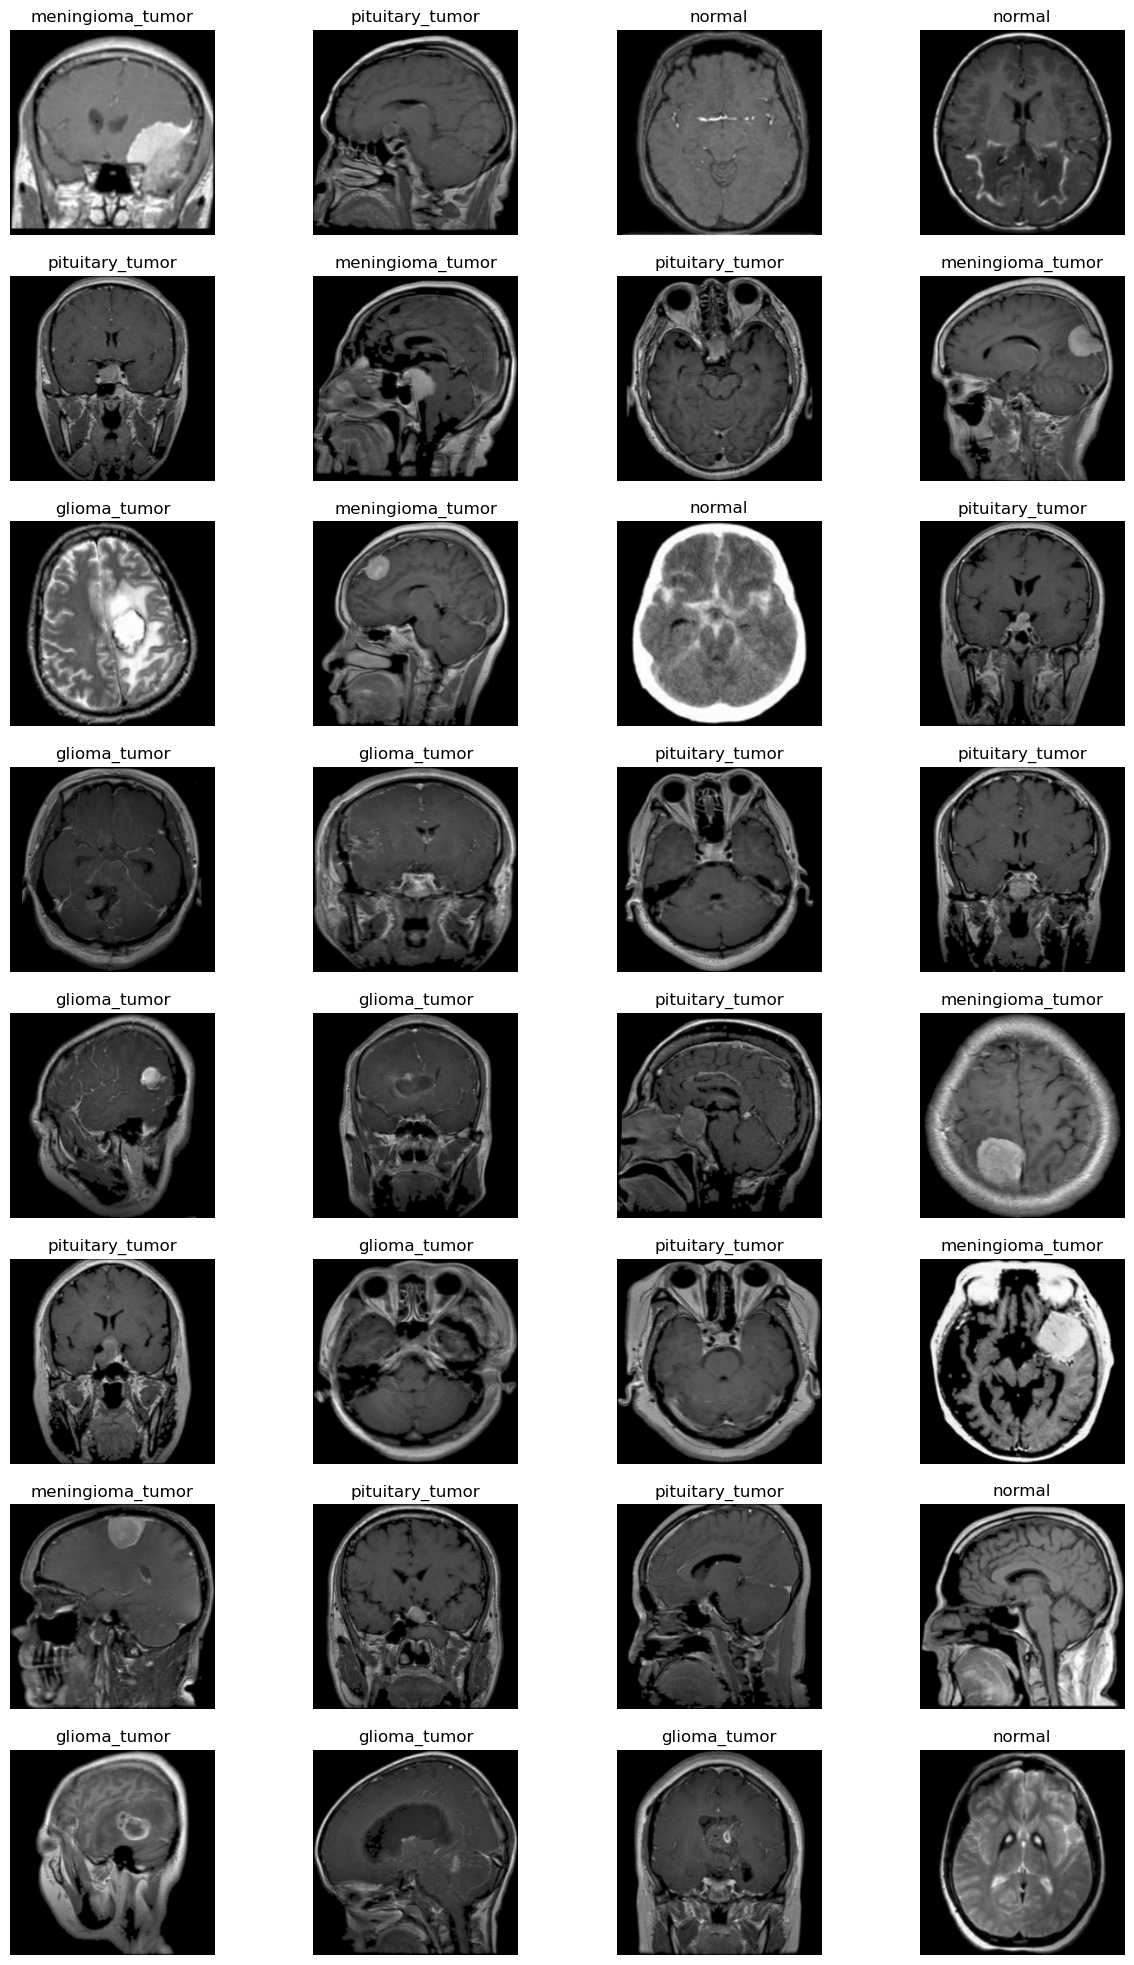

In [6]:
plt.figure(figsize=(15, 25))
for images, labels in train.take(1):
    for i in range(32):
        ax = plt.subplot(8, 4, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [3]:
base_model = None
model = None
with tf.device('/device:GPU:0'):
  base_model = tf.keras.applications.VGG16(input_shape=(224,224,3),include_top=False,weights='imagenet')
  base_model.trainable = False
  model=keras.models.Sequential()
  model.add(base_model)
  model.add(keras.layers.Flatten())
  model.add(keras.layers.Dropout(.5))
  model.add(keras.layers.Dense(4,activation=tf.nn.softmax))
  model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dropout (Dropout)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 4)                 100356    
                                                                 
Total params: 14815044 (56.51 MB)
Trainable params: 100356 (392.02 KB)
Non-trainable params: 14714688 (56.13 MB)
_________________________________________________________________


In [9]:
tf.keras.utils.plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True,show_dtype=True,dpi=120)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [10]:
checkpoint_cb =ModelCheckpoint("vgg6_model.h5", save_best_only=True)
early_stopping_cb =EarlyStopping(patience=5, restore_best_weights=True)
model.compile(optimizer ='adam',loss='sparse_categorical_crossentropy', metrics=['accuracy'])
hist=model.fit_generator(train,epochs=20,validation_data=validation,callbacks=[checkpoint_cb,early_stopping_cb])
model.save("vgg16_model.h5")

Epoch 1/20
62/62 [==============================] - 184s 3s/step - loss: 9.6777 - accuracy: 0.6596 - val_loss: 1.7339 - val_accuracy: 0.8889
Epoch 2/20
62/62 [==============================] - 177s 3s/step - loss: 2.3947 - accuracy: 0.8697 - val_loss: 1.0800 - val_accuracy: 0.9374
Epoch 3/20
62/62 [==============================] - 180s 3s/step - loss: 1.7623 - accuracy: 0.8960 - val_loss: 0.8732 - val_accuracy: 0.9576
Epoch 4/20
62/62 [==============================] - 178s 3s/step - loss: 1.1085 - accuracy: 0.9288 - val_loss: 0.9035 - val_accuracy: 0.9556
Epoch 5/20
62/62 [==============================] - 173s 3s/step - loss: 1.0824 - accuracy: 0.9359 - val_loss: 0.6591 - val_accuracy: 0.9576
Epoch 6/20
62/62 [==============================] - 168s 3s/step - loss: 0.9159 - accuracy: 0.9434 - val_loss: 0.8235 - val_accuracy: 0.9636
Epoch 7/20
62/62 [==============================] - 172s 3s/step - loss: 0.5713 - accuracy: 0.9535 - val_loss: 0.9890 - val_accuracy: 0.9657
Epoch 8/20
62

In [12]:
score, acc = model.evaluate(validation)
print('Test Loss =', score)
print('Test Accuracy =', acc)

16/16 [==============================] - 35s 2s/step - loss: 0.6591 - accuracy: 0.9576
Test Loss = 0.6591076850891113
Test Accuracy = 0.9575757384300232


In [13]:
hist_=pd.DataFrame(hist.history)
hist_

,loss,accuracy,val_loss,val_accuracy
0,9.677707,0.659596,1.733859,0.888889
1,2.394695,0.869697,1.079963,0.937374
2,1.762264,0.895960,0.873166,0.957576
3,1.108473,0.928788,0.903537,0.955556
4,1.082410,0.935859,0.659108,0.957576
5,0.915852,0.943434,0.823547,0.963636
6,0.571316,0.953535,0.989028,0.965657
7,0.663771,0.956566,1.484828,0.945455
8,0.636576,0.964646,1.022437,0.969697
9,0.441322,0.970202,0.840718,0.969697


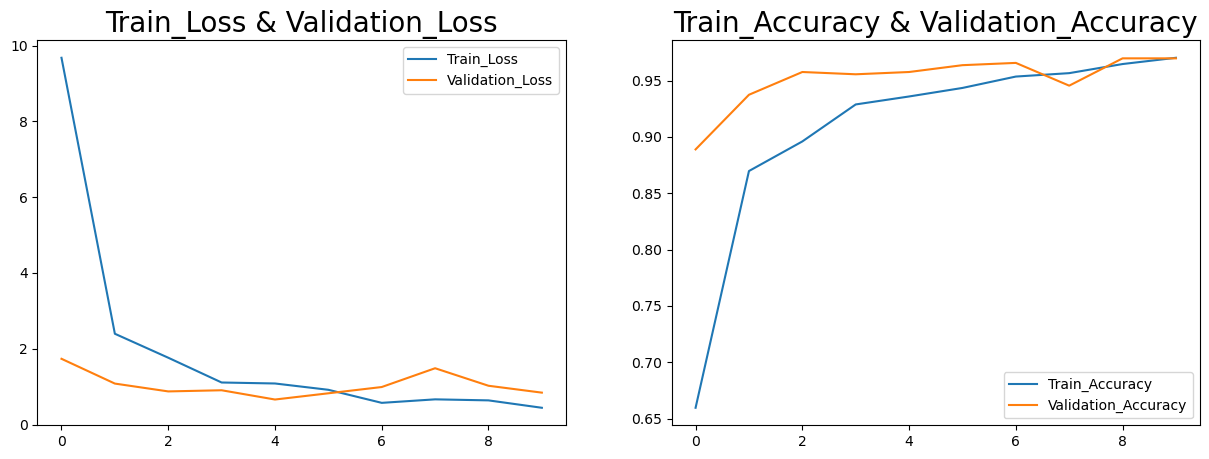

In [14]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.plot(hist_['loss'],label='Train_Loss')
plt.plot(hist_['val_loss'],label='Validation_Loss')
plt.title('Train_Loss & Validation_Loss',fontsize=20)
plt.legend()
plt.subplot(1,2,2)
plt.plot(hist_['accuracy'],label='Train_Accuracy')
plt.plot(hist_['val_accuracy'],label='Validation_Accuracy')
plt.title('Train_Accuracy & Validation_Accuracy',fontsize=20)
plt.legend()

In [15]:
X_val,y_val,y_pred=[],[],[]
for images, labels in validation:
    y_val.extend(labels.numpy())
    X_val.extend(images.numpy())
predictions=model.predict(np.array(X_val))
for i in predictions:
    y_pred.append(np.argmax(i))
df=pd.DataFrame()
df['Actual'],df['Prediction']=y_val,y_pred
df

16/16 [==============================] - 37s 2s/step


,Actual,Prediction
0,1,1
1,1,1
2,1,2
3,1,1
4,0,0
...,...,...
490,2,2
491,0,0
492,1,0
493,1,1


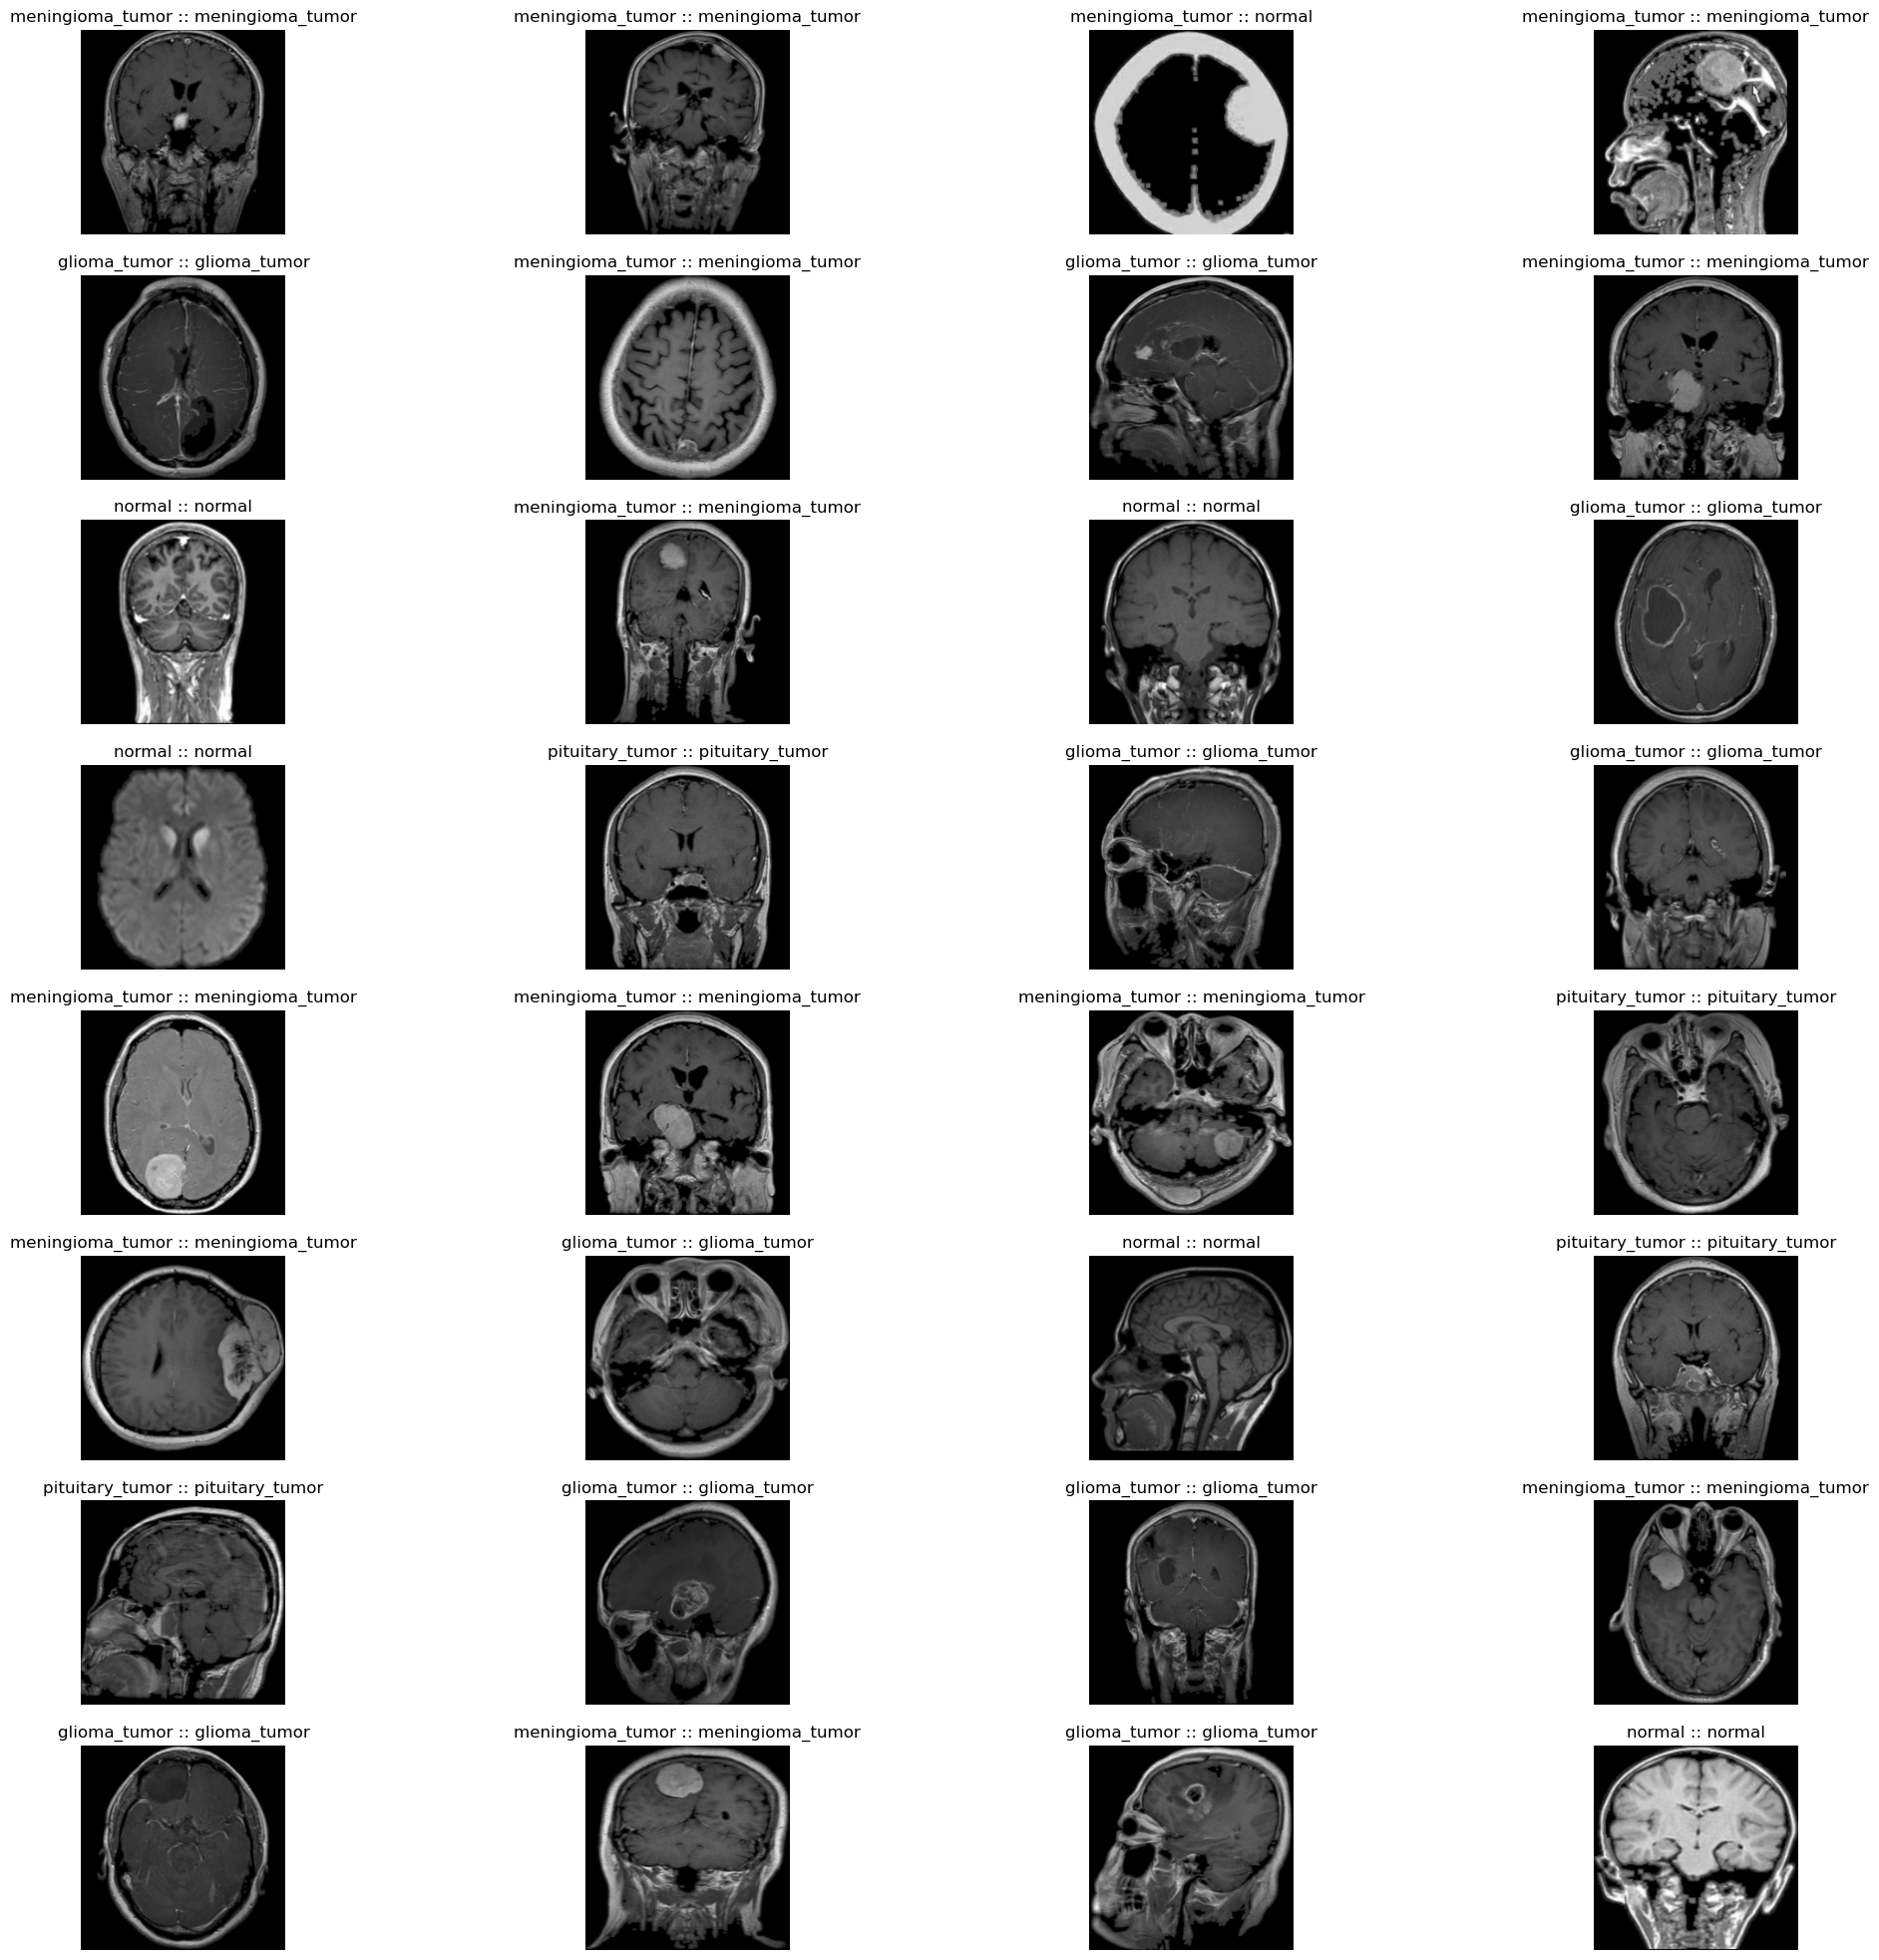

In [16]:
plt.figure(figsize=(25,25))
for i in range(32):
    ax = plt.subplot(8, 4, i + 1)
    plt.imshow(X_val[i].astype("uint8"))
    plt.title(f'{class_names[y_val[i]]} :: {class_names[y_pred[i]]}')
    plt.axis("off")

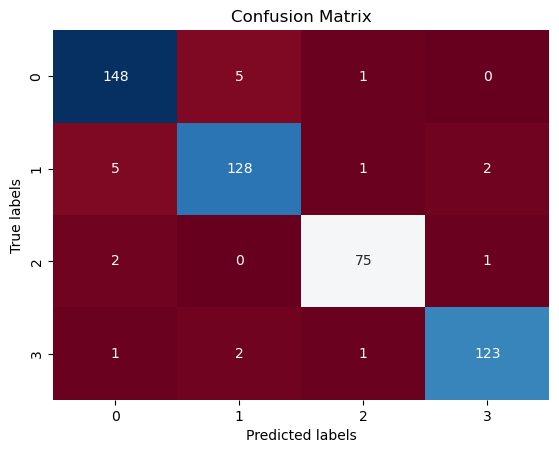

array([[148,   5,   1,   0],
       [  5, 128,   1,   2],
       [  2,   0,  75,   1],
       [  1,   2,   1, 123]])

In [17]:
ax= plt.subplot()
CM = confusion_matrix(y_val,y_pred)
sns.heatmap(CM, annot=True, fmt='g', ax=ax,cbar=False,cmap='RdBu')
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')
plt.show()
CM

In [19]:
ClassificationReport = classification_report(y_val,y_pred)
print('Classification Report is : ', ClassificationReport )

Classification Report is :                precision    recall  f1-score   support

           0       0.95      0.96      0.95       154
           1       0.95      0.94      0.94       136
           2       0.96      0.96      0.96        78
           3       0.98      0.97      0.97       127

    accuracy                           0.96       495
   macro avg       0.96      0.96      0.96       495
weighted avg       0.96      0.96      0.96       495



In [11]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from keras.preprocessing.image import load_img, img_to_array

# Load the model
model = tf.keras.models.load_model("vgg16_model.h5")

# Define your label mapping
id2label = {2: 'normal', 0: 'glioma_tumor',
            1: 'meningioma_tumor', 3: 'pituitary_tumor'}

# Directory containing your test images
image_dir = '/Users/cnacode/projects/BrainSynergy/data/kaggle_solutionSet'

# Target size for image resizing
target_size = (224, 224)

# Prepare DataFrame for results
df_result = pd.DataFrame(columns=['ID', 'prediction'])

# Process each image in the directory
for filename in sorted(os.listdir(image_dir)):
    if filename.endswith(('.bmp', '.gif', '.jpeg', '.jpg', '.png')):
        # Load and preprocess the image
        img_path = os.path.join(image_dir, filename)
        img = load_img(img_path, target_size=target_size)
        img_array = img_to_array(img)
        # Model expects a batch of images
        img_array = np.expand_dims(img_array, axis=0)

        # Make a prediction
        prediction = model.predict(img_array)
        print(prediction)
        predicted_label_index = np.argmax(prediction)
        predicted_label = id2label[predicted_label_index]

        # Append to DataFrame
        df_result = df_result.append(
            {'ID': filename, 'prediction': predicted_label}, ignore_index=True)

# Save DataFrame to CSV
df_result.to_csv('predicted_labels.csv', index=False)

1/1 [==============================] - 0s 161ms/step
[[7.892942e-12 1.000000e+00 0.000000e+00 3.759010e-34]]
1/1 [==============================] - 0s 112ms/step
[[5.8675337e-33 1.0000000e+00 0.0000000e+00 0.0000000e+00]]
1/1 [==============================] - 0s 146ms/step
[[7.14456e-10 1.00000e+00 0.00000e+00 0.00000e+00]]
1/1 [==============================] - 0s 123ms/step
[[1.0363588e-27 9.9984992e-01 2.6480169e-37 1.5002109e-04]]
1/1 [==============================] - 0s 135ms/step
[[2.9943873e-32 1.3302516e-11 0.0000000e+00 1.0000000e+00]]
1/1 [==============================] - 0s 107ms/step
[[3.1128732e-14 1.0000000e+00 0.0000000e+00 0.0000000e+00]]
1/1 [==============================] - 0s 106ms/step
[[9.9999392e-01 2.8523292e-14 1.0852573e-19 6.0528773e-06]]
1/1 [==============================] - 0s 114ms/step
[[0. 1. 0. 0.]]
1/1 [==============================] - 0s 153ms/step
[[1.6890976e-05 9.9998307e-01 0.0000000e+00 6.2682607e-34]]
1/1 [==============================] - 